# AMR RISK CLASSIFICATION IN LIVE-STOCKS

### DATA PRE-PROCESSESING

In this first notebook, the needed pre-processing has been performed in order prepare the data for the analysis.

In [1]:
# LIBRARIES

# Basics
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import math


# Scikit learn - models
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression # used for RFE
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

# Scikit learn - feature engineering 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier

/Users/aydanselek/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/Users/aydanselek/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


##### READ THE DATA

There are 5 different datasets: 3 of them are for the AMR test results and 2 of them are for the antibitic consumption. They are collected / extracted from database in various formats and years.

In [2]:
# read all test data I have
amr_data1 = pd.read_csv("New_test_data.txt", sep="\t", header=None) #2002-2015
amr_data2 = pd.read_excel("AMR data.xlsx") #2018
amr_data3 = pd.read_excel("AMR data 2017.xlsx") #2017

In [3]:
# read all consumption data I have
consumption_data1 = pd.read_excel('consumption_2013.xlsx') #2013
consumption_data2 = pd.read_csv('Drug Consumption data.csv') #2014-2017

##### RENAMING THE COLUMNS AND DIMENTION REDUCTION

It is needed to fix the same names across different datasets. This chunk of the code serves also for keeping the needed columns v.v. droping the unnecessary columns.

In [4]:
# amr_data1
amr_data1 = amr_data1.rename(index=str, columns={0: "Year", 6:"Active_principle", 7:"Farm_ID", 9:"Result", 10:"Bacteria", 12:"Kind"}) # this data was without header, renaming of columns 
amr_data1 = amr_data1[['Year', 'Active_principle', 'Farm_ID', 'Result', 'Bacteria', 'Kind']] # the columns I need
amr_data1 = amr_data1.loc[amr_data1['Kind'].isin(['SUINO', 'SUINO - SVEZZAMENTO', 'SUINO - SOTTOSCROFA', 'SUINO - MAGRONE', 'SUINO - SCROFETTA', 'SUINO - INGRASSO', 'SUINO - SCROFA', 'SUINO - VERRO', 'SUINO DI RAZZA MORA', 'SUINO DI RAZZA CINTA SENESE'])] # Only Suino

In [5]:
# amr_data2
amr_data2 = amr_data2.rename(index=str, columns={'AnnoConferimento': "Year", 'Antibiotico':"Active_principle", 'Codice_Allevix':"Farm_ID", 'Risultato':"Result", 'AgenteEziologico':"Bacteria", 'Specie':"Kind"}) # this data was with italian header, renaming of columns 
amr_data2 = amr_data2[['Year', 'Active_principle', 'Farm_ID', 'Result', 'Bacteria', 'Kind']] # the columns I need
amr_data2 = amr_data2.loc[amr_data2['Kind'].isin(['SUINO', 'SUINO - SVEZZAMENTO', 'SUINO - SOTTOSCROFA', 'SUINO - MAGRONE', 'SUINO - SCROFETTA', 'SUINO - INGRASSO', 'SUINO - SCROFA'])] # Only Suino

In [6]:
# amr_data3
amr_data3 = amr_data3.rename(index=str, columns={'AnnoConferimento': "Year", 'Antibiotico':"Active_principle", 'Codice_Allevix':"Farm_ID", 'Risultato':"Result", 'AgenteEziologico':"Bacteria", 'Specie':"Kind"}) # this data was with italian header, renaming of columns 
amr_data3 = amr_data3[['Year', 'Active_principle', 'Farm_ID', 'Result', 'Bacteria', 'Kind']] # the columns I need
amr_data3 = amr_data3.loc[amr_data3['Kind'].isin(['SUINO', 'SUINO - SVEZZAMENTO', 'SUINO - SOTTOSCROFA', 'SUINO - MAGRONE', 'SUINO - SCROFETTA', 'SUINO - INGRASSO', 'SUINO - SCROFA', 'SUINO - VERRO'])] # Only Suino

In [7]:
# consumption_data1
consumption_data1 = consumption_data1[['PK_Somministrazione', 'IdAllevamento', 'Year', 'CicloAperto', 'CicloChiuso', 
                     'Sito1', 'Sito3', 'TipoFarmaco', 'Target', 'PrincipioAttivo', 'PrincipioSomministratoMg',
                     'DDDA_Mille','DCDA_Mille']] # the columns I need

consumption_data1 = consumption_data1.rename(index=str, columns={'Year': "Year", 'PK_Somministrazione':"PK_Somministrazione", 'IdAllevamento':"Farm_ID", 'PrincipioAttivo':"Active_principle", 'CicloAperto': 'Open_cycle', 'CicloChiuso': 'Close_cycle', 
                     'Sito1': 'Site1', 'Sito3': 'Site3', 'TipoFarmaco': 'Type_of_medication', 'Target': 'Target', 'PrincipioSomministratoMg': 'Active_principle_mg',
                     'DDDA_Mille': 'DDDA','DCDA_Mille': 'DCDA'}) # rename in English

In [8]:
# consumption_data2
consumption_data2 = consumption_data2[['PK_Somministrazione', 'IdAllevamento', 'n_AnnoSomm', 'CicloAperto', 'CicloChiuso', 
                     'Sito1', 'Sito3', 'TipoFarmaco', 'Target', 'PrincipioAttivo', 'PrincipioSomministratoMg',
                     'DDDA_Mille','DCDA_Mille']] # the columns I need

consumption_data2 = consumption_data2.rename(index=str, columns={'n_AnnoSomm': "Year", 'PK_Somministrazione':"PK_Somministrazione", 'IdAllevamento':"Farm_ID", 'PrincipioAttivo':"Active_principle", 'CicloAperto': 'Open_cycle', 'CicloChiuso': 'Close_cycle', 
                     'Sito1': 'Site1', 'Sito3': 'Site3', 'TipoFarmaco': 'Type_of_medication', 'Target': 'Target', 'PrincipioSomministratoMg': 'Active_principle_mg',
                     'DDDA_Mille': 'DDDA','DCDA_Mille': 'DCDA'}) # rename in English

##### UPPERCASE

All the values in string need to turn in uppercase to unify the format.

In [9]:
amr_data1 = amr_data1.applymap(lambda s:s.upper() if type(s) == str else s)
amr_data2 = amr_data2.applymap(lambda s:s.upper() if type(s) == str else s)
amr_data3 = amr_data3.applymap(lambda s:s.upper() if type(s) == str else s)

In [10]:
consumption_data1 = consumption_data1.applymap(lambda s:s.upper() if type(s) == str else s)
consumption_data2 = consumption_data2.applymap(lambda s:s.upper() if type(s) == str else s)

##### # OF MISSING VALUES

In [11]:
amr_data1.isnull().sum()

Year                0
Active_principle    0
Farm_ID             0
Result              0
Bacteria            0
Kind                0
dtype: int64

In [12]:
amr_data2.isnull().sum()

Year                0
Active_principle    0
Farm_ID             0
Result              0
Bacteria            0
Kind                0
dtype: int64

In [13]:
amr_data3.isnull().sum()

Year                   0
Active_principle       0
Farm_ID             3541
Result                 0
Bacteria               0
Kind                   0
dtype: int64

In [14]:
consumption_data1.isnull().sum()

PK_Somministrazione      0
Farm_ID                  0
Year                     0
Open_cycle               0
Close_cycle              0
Site1                    0
Site3                    0
Type_of_medication       0
Target                   1
Active_principle         0
Active_principle_mg      0
DDDA                   816
DCDA                   816
dtype: int64

In [15]:
consumption_data2.isnull().sum()

PK_Somministrazione    0
Farm_ID                0
Year                   0
Open_cycle             0
Close_cycle            0
Site1                  0
Site3                  0
Type_of_medication     0
Target                 0
Active_principle       0
Active_principle_mg    0
DDDA                   0
DCDA                   0
dtype: int64

##### # OF ACTIVE PRINCIPLE (FOR INFORMATION)

In [16]:
len(amr_data1.Active_principle.unique())

94

In [17]:
len(amr_data2.Active_principle.unique())

49

In [18]:
len(amr_data3.Active_principle.unique())

60

In [19]:
len(consumption_data1.Active_principle.unique())

36

In [20]:
len(consumption_data2.Active_principle.unique())

44

##### # OF BACTERIA (FOR INFORMATION)

In [21]:
len(amr_data1.Bacteria.unique())

171

In [22]:
len(amr_data2.Bacteria.unique())

44

In [23]:
len(amr_data3.Bacteria.unique())

56

##### # OF FARM (FOR INFORMATION)

In [24]:
len(amr_data1.Farm_ID.unique())

3053

In [25]:
len(amr_data2.Farm_ID.unique())

779

In [26]:
len(amr_data3.Farm_ID.unique())

827

In [27]:
len(consumption_data1.Farm_ID.unique())

135

In [28]:
len(consumption_data2.Farm_ID.unique())

430

##### MERGING ALL THE AMR TEST DATA AND THE CONSUMPTION DATA

The AMR test results data and the antibiotic consumption data can be merged in two datesets.

In [29]:
frames = [amr_data1, amr_data2, amr_data3]
amr_data = pd.concat(frames, ignore_index=True)

In [30]:
amr_data.head()

,Year,Active_principle,Farm_ID,Result,Bacteria,Kind
0,2013,AMINOSIDINA,000EX000,RESISTENTE,ESCHERICHIA COLI EMOLITICO,SUINO
1,2013,APRAMICINA,000EX000,RESISTENTE,ESCHERICHIA COLI EMOLITICO,SUINO
2,2013,CEFQUINOME,000EX000,SENSIBILE,ESCHERICHIA COLI EMOLITICO,SUINO
3,2013,CEFTIOFUR,000EX000,SENSIBILE,ESCHERICHIA COLI EMOLITICO,SUINO
4,2013,COLISTINA,000EX000,SENSIBILE,ESCHERICHIA COLI EMOLITICO,SUINO


In [31]:
frames2 = [consumption_data1, consumption_data2]
consumption_data = pd.concat(frames2, ignore_index=True)

In [32]:
consumption_data.head()

,PK_Somministrazione,Farm_ID,Year,Open_cycle,Close_cycle,Site1,Site3,Type_of_medication,Target,Active_principle,Active_principle_mg,DDDA,DCDA
0,327,001MN006,2013,0,0,0,0,INJ,---,AMPICILLIN,23825.0,2500.00,1250.00
1,327,001MN006,2013,0,0,0,0,INJ,---,DICLOXACILLIN,11950.0,2500.00,1250.00
2,328,001MN006,2013,0,0,0,0,ORAL POWD,---,DOXYCYCLINE,1000000.0,100000.00,20000.00
3,329,001MN006,2013,0,0,0,0,INJ,---,FLORFENICOL,75000.0,10000.00,2500.00
4,330,001MN006,2013,0,0,0,0,PREMIX,---,COLISTIN,1440000.0,261818.18,29090.91


##### ACTIVE PRINCIPLE CLEANING

The amr_data has some problems for the active principle which cannot be solvable in an automated manner. Some of the active principle are in Italian language, some of them are in English language. There are typos which is not easy to understand typo of which language. More over there are some active principle which are translated not in a proper way. 
Because of these problems I collected all unique values of "Active Principle" to create a mapping excel with right names. This will let me compare the active principle across the datasets.
More over, I added to this excel another column where I classified the importance of the active priciples, such as;
1 - VCIA: Veterinary Critically Important Antimicrobials 
2 - VHIA: Veterinary Highly Important Antimicrobials 
3 - VIA: Veterinary Important Antimicrobials

In [33]:
active_principle_info = pd.read_excel("Active_principle_map.xlsx")

In [34]:
active_principle_info

,Active_principle,English_name,Value
0,ACIDO FUSIDICO,FUSIDIC ACID,3.0
1,ACIDO NALIDIXICO,NALIDIXIC ACID,2.0
2,ACIDO OXOLINICO,OXOLINIC ACID,2.0
3,AMIKACINA,AMIKACIN,1.0
4,AMINOSIDINA,PAROMOMYCIN,1.0
5,AMOXICILLIN,AMOXICILLIN,1.0
6,AMOXICILLINA,AMOXICILLIN,1.0
7,AMOXICILLINA + AC.CLAVULANICO,AMOXICILLIN + CLAVULANIC ACID,1.0
8,AMOXICILLINA + COLISTINA,AMOXICILLIN + COLISTIN,NaN
9,AMPICILLIN,AMPICILLIN,1.0


In [35]:
amr_data_ap = pd.merge(amr_data, active_principle_info, on='Active_principle', how='inner')

In [36]:
amr_data_ap = amr_data_ap.drop(['Active_principle'], axis=1)

In [37]:
amr_data_ap = amr_data_ap.rename(index=str, columns={'English_name': "Active_principle"})

##### TRANSLATE THE VALUES IN ENGLISH

It is nice to work always in same language. Here the 'Result' column values translated in English.

In [38]:
amr_data_ap.Result.replace(['RESISTENTE', 'SENSIBILE', 'INTERMEDIO'], ['RESISTANT', 'SENSITIVE', 'INTERMEDIATE'], inplace=True)

##### DATA TRANSFORMATION - AGGREGATE THE RELATED CONSUMPTIONS

Because of the unautomated data collection and the nature of the drug consumption, there are multiple lines for each antibiotic consumption. For the health of the analysis, it is needed to sum same antibiotic comsumption which are belong to same farm, same year, same methodology and same type of medication.

In [39]:
# Drop more column 
consumption_data = consumption_data.drop(['PK_Somministrazione', 'Site1', 'Site3', 'Target'], axis=1)

In [40]:
# New dataframe with grouped featues
consumption_data_grouped = consumption_data.groupby(['Farm_ID', 'Year', 'Open_cycle', 'Close_cycle', 'Type_of_medication', 'Active_principle'], as_index= False).sum()

In [41]:
len(consumption_data_grouped) # 8421 records less!!

10431

##### CREATE THE GIANT DATASET

In [42]:
all_data = pd.merge(amr_data_ap, consumption_data_grouped, on=['Year', 'Farm_ID', 'Active_principle'], how='inner')

In [43]:
writer = pd.ExcelWriter('all_data.xlsx')
all_data.to_excel(writer,'Sheet1')
writer.save()

In [44]:
len(all_data)

6564

In [45]:
all_data = all_data[['Year', 'Farm_ID', 'Bacteria', 'Kind', 'Active_principle', 'Value', 'Open_cycle', 'Close_cycle', 'Type_of_medication', 'Active_principle_mg', 'DDDA', 'DCDA', 'Result']]

In [46]:
all_data.head()

,Year,Farm_ID,Bacteria,Kind,Active_principle,Value,Open_cycle,Close_cycle,Type_of_medication,Active_principle_mg,DDDA,DCDA,Result
0,2014,002MN008,ESCHERICHIA COLI,SUINO,PAROMOMYCIN,1.0,1,0,INJ,656250.0,44948.63,11237.16,SENSITIVE
1,2014,002MN008,GEN. STREPTOCOCCUS,SUINO,PAROMOMYCIN,1.0,1,0,INJ,656250.0,44948.63,11237.16,RESISTANT
2,2015,003PC001,GEN. STREPTOCOCCUS,SUINO,PAROMOMYCIN,1.0,1,0,INJ,43750.0,4166.67,1041.67,INTERMEDIATE
3,2015,003PC001,ACTINOBACILLUS PLEUROPNEUMONIAE BIOTIPO 1,SUINO,PAROMOMYCIN,1.0,1,0,INJ,43750.0,4166.67,1041.67,RESISTANT
4,2015,003PC001,GEN. STREPTOCOCCUS,SUINO,PAROMOMYCIN,1.0,1,0,INJ,43750.0,4166.67,1041.67,INTERMEDIATE


In [70]:
len(all_data.Farm_ID.unique())

126

##### DATA PREPARATION FOR THE ANAYSIS

In [112]:
# Drop the identify columns
dataset_with_identity = all_data
dataset = all_data.drop(['Kind', 'Farm_ID'], axis=1)

In [113]:
# Drop nan values
dataset.dropna(inplace=True)
dataset_with_identity.dropna(inplace=True)

##### MEAN REMOVAL (STANDARDIZATION)

In [49]:
#print('Mean before=', dataset.mean(axis=0))
#print('Standard Deviation before=', dataset.std(axis=0))

In [50]:
#ss = preprocessing.StandardScaler()
#dataset[['Active_principle_mg', 'DDDA', 'DCDA']] = ss.fit_transform(dataset[['Active_principle_mg', 'DDDA', 'DCDA']])
#print('Mean after=', dataset.mean(axis=0))
#print('Standard Deviation after=', dataset.std(axis=0))

##### NORMALIZATION

In [51]:
#dataset[['Active_principle_mg', 'DDDA', 'DCDA']] = preprocessing.normalize(dataset[['Active_principle_mg', 'DDDA', 'DCDA']], norm='l1')

In [52]:
#dataset_with_FarmID[['Active_principle_mg', 'DDDA', 'DCDA']] = preprocessing.normalize(dataset_with_FarmID[['Active_principle_mg', 'DDDA', 'DCDA']], norm='l2')

##### DEALING WITH THE CATEGORICAL DATA / Onehot Encoder

In [53]:
#no_onehot_cols = ['Year','Result', 'Active_principle_mg', 'DDDA', 'DCDA', 'Open_cycle', 'Close_cycle'] 
#onehot_cols = list(set(dataset.columns) - set(no_onehot_cols))
#onehot_dataset = pd.get_dummies(dataset, columns=onehot_cols)

In [54]:
#cols = list(onehot_dataset.columns.values)
#cols

In [55]:
dataset

,Year,Bacteria,Active_principle,Value,Open_cycle,Close_cycle,Type_of_medication,Active_principle_mg,DDDA,DCDA,Result
0,2014,ESCHERICHIA COLI,PAROMOMYCIN,1.0,1,0,INJ,656250.0,44948.63,11237.16,SENSITIVE
1,2014,GEN. STREPTOCOCCUS,PAROMOMYCIN,1.0,1,0,INJ,656250.0,44948.63,11237.16,RESISTANT
2,2015,GEN. STREPTOCOCCUS,PAROMOMYCIN,1.0,1,0,INJ,43750.0,4166.67,1041.67,INTERMEDIATE
3,2015,ACTINOBACILLUS PLEUROPNEUMONIAE BIOTIPO 1,PAROMOMYCIN,1.0,1,0,INJ,43750.0,4166.67,1041.67,RESISTANT
4,2015,GEN. STREPTOCOCCUS,PAROMOMYCIN,1.0,1,0,INJ,43750.0,4166.67,1041.67,INTERMEDIATE
5,2015,PASTEURELLA MULTOCIDA,PAROMOMYCIN,1.0,1,0,INJ,43750.0,4166.67,1041.67,SENSITIVE
6,2015,ESCHERICHIA COLI,PAROMOMYCIN,1.0,1,0,INJ,43750.0,4166.67,1041.67,RESISTANT
7,2015,ESCHERICHIA COLI EMOLITICO,PAROMOMYCIN,1.0,0,0,ORAL SOLU,1000000.0,30769.23,7692.31,SENSITIVE
8,2015,PASTEURELLA MULTOCIDA,PAROMOMYCIN,1.0,1,0,INJ,43750.0,2996.58,749.14,SENSITIVE
9,2015,PASTEURELLA MULTOCIDA,PAROMOMYCIN,1.0,1,0,PREMIX,400000.0,12307.70,3076.92,SENSITIVE


In [114]:
dataset_with_identity.head()

,Year,Farm_ID,Bacteria,Kind,Active_principle,Value,Open_cycle,Close_cycle,Type_of_medication,Active_principle_mg,DDDA,DCDA,Result
0,2014,002MN008,ESCHERICHIA COLI,SUINO,PAROMOMYCIN,1.0,1,0,INJ,656250.0,44948.63,11237.16,SENSITIVE
1,2014,002MN008,GEN. STREPTOCOCCUS,SUINO,PAROMOMYCIN,1.0,1,0,INJ,656250.0,44948.63,11237.16,RESISTANT
2,2015,003PC001,GEN. STREPTOCOCCUS,SUINO,PAROMOMYCIN,1.0,1,0,INJ,43750.0,4166.67,1041.67,INTERMEDIATE
3,2015,003PC001,ACTINOBACILLUS PLEUROPNEUMONIAE BIOTIPO 1,SUINO,PAROMOMYCIN,1.0,1,0,INJ,43750.0,4166.67,1041.67,RESISTANT
4,2015,003PC001,GEN. STREPTOCOCCUS,SUINO,PAROMOMYCIN,1.0,1,0,INJ,43750.0,4166.67,1041.67,INTERMEDIATE


##### DEALING WITH THE CATEGORICAL DATA / Label Encoder

One-hot Encoder increases the accuracy of the models more than Label Encoder. For this reason, I will keep the One-Hot Encoder rather than Label Encoder.

In [115]:
pd.options.mode.chained_assignment = None

#le_Bacteria = preprocessing.LabelEncoder()
#le_Active_principle = preprocessing.LabelEncoder()
#le_Type_of_medication = preprocessing.LabelEncoder()
#le_Result = preprocessing.LabelEncoder()
#le_Year = preprocessing.LabelEncoder()
#le_Kind = preprocessing.LabelEncoder()
#le_Farm_ID = preprocessing.LabelEncoder()


#dataset['Bacteria'] = le_Bacteria.fit_transform(dataset['Bacteria'])
#dataset['Active_principle'] = le_Active_principle.fit_transform(dataset['Active_principle'])
#dataset['Type_of_medication'] = le_Type_of_medication.fit_transform(dataset['Type_of_medication'])
#dataset['Result'] = le_Result.fit_transform(dataset['Result'])
#dataset['Kind'] = le_Kind.fit_transform(dataset['Kind'])
#dataset['Farm_ID'] = le_Farm_ID.fit_transform(dataset['Farm_ID'])
#dataset['Year'] = le_Year.fit_transform(dataset['Year'])

In [117]:
# For dataset_with_identity with identity

le_Bacteria = preprocessing.LabelEncoder()
le_Active_principle = preprocessing.LabelEncoder()
le_Type_of_medication = preprocessing.LabelEncoder()
le_Result = preprocessing.LabelEncoder()
le_Year = preprocessing.LabelEncoder()
le_Kind = preprocessing.LabelEncoder()
le_Farm_ID = preprocessing.LabelEncoder()


dataset_with_identity['Bacteria'] = le_Bacteria.fit_transform(dataset_with_identity['Bacteria'])
dataset_with_identity['Active_principle'] = le_Active_principle.fit_transform(dataset_with_identity['Active_principle'])
dataset_with_identity['Type_of_medication'] = le_Type_of_medication.fit_transform(dataset_with_identity['Type_of_medication'])
dataset_with_identity['Result'] = le_Result.fit_transform(dataset_with_identity['Result'])
dataset_with_identity['Kind'] = le_Kind.fit_transform(dataset_with_identity['Kind'])
dataset_with_identity['Farm_ID'] = le_Farm_ID.fit_transform(dataset_with_identity['Farm_ID'])
dataset_with_identity['Year'] = le_Year.fit_transform(dataset_with_identity['Year'])

##### SPLITTING THE DATA

In [118]:
X = dataset_with_identity.loc[:, 'Year':'DCDA']
Y = dataset_with_identity[['Result']]

In [119]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [120]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(5337, 12)
(593, 12)
(5337, 1)
(593, 1)


### FEATURE ENGINEERING

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

The chi squared statistical test for non-negative features to select 4 of the best features.

In [121]:
#exogenes = dataset[['Bacteria', 'Active_principle', 'Value', 'Open_cycle',
#       'Close_cycle', 'Type_of_medication','Active_principle_mg', 'DDDA', 'DCDA', 'Year', 'Kind', 'Farm_ID']]
#target = dataset[['Result']]

In [122]:
# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)

unvariate = SelectKBest(score_func=chi2, k=4)
unvariate_fit = unvariate.fit(X, Y)
# summarize scores
np.set_printoptions(precision=3)
print(unvariate_fit.scores_)
features = unvariate_fit.transform(X)
#summarize selected features
print(features[0:5,:])     #VALUE, DDDA AND THE CLOSE CYCLE, ADDITIONALLY BACTERIA

[  1.269e+00   5.974e+02   2.810e+01   2.601e+00   1.350e+03   9.524e+00
   1.019e+00   4.351e+00   2.447e+02   1.499e+10   8.574e+08   1.559e+08]
[[  1.300e+01   6.562e+05   4.495e+04   1.124e+04]
 [  1.300e+01   6.562e+05   4.495e+04   1.124e+04]
 [  1.300e+01   4.375e+04   4.167e+03   1.042e+03]
 [  1.300e+01   4.375e+04   4.167e+03   1.042e+03]
 [  1.300e+01   4.375e+04   4.167e+03   1.042e+03]]


In [62]:
# Feature Extraction with RFE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

model = LogisticRegression(penalty='l1')
rfe = RFE(model, 4)
rfe_fit = rfe.fit(X, Y.values.ravel())
print(("Num Features: %d") % (rfe_fit.n_features_))
print(("Selected Features: %s") % rfe_fit.support_)
print(("Feature Ranking: %s") % rfe_fit.ranking_) #L1 VALUE, OPEN CYCLE, CLOSE CYCLE, TYPE OF MEDICATION

Num Features: 4
Selected Features: [False False False  True  True  True  True False False False]
Feature Ranking: [3 4 2 1 1 1 1 7 6 5]


In [63]:
model = LogisticRegression(penalty='l2')
rfe = RFE(model, 4)
rfe_fit = rfe.fit(X, Y.values.ravel())
print(("Num Features: %d") % (rfe_fit.n_features_))
print(("Selected Features: %s") % rfe_fit.support_)
print(("Feature Ranking: %s") % rfe_fit.ranking_) #L2 BACTERIA, ACTIVE PRINCIPLE, DDDA and DCDA

Num Features: 4
Selected Features: [False  True  True False False False False False  True  True]
Feature Ranking: [3 1 1 4 6 7 5 2 1 1]


In [64]:
# Feature Extraction with PCA
pca = PCA(n_components=4)
pca_fit = pca.fit(X)
# summarize components
print(("Explained Variance: %s") % pca_fit.explained_variance_ratio_)
print(pca_fit.components_)

Explained Variance: [  9.984e-01   1.579e-03   2.194e-05   1.219e-14]
[[ -7.704e-10  -1.037e-09  -5.904e-09  -2.617e-10  -4.236e-10  -5.978e-11
    5.598e-09   9.965e-01   8.205e-02   1.656e-02]
 [ -2.954e-09  -4.055e-08   2.394e-07   4.048e-08  -1.714e-10  -1.735e-10
    1.817e-08  -8.370e-02   9.736e-01   2.126e-01]
 [ -6.712e-08  -3.506e-07   2.010e-06   1.743e-07  -3.163e-08  -5.774e-09
    5.256e-07  -1.321e-03   2.132e-01  -9.770e-01]
 [  6.730e-03   1.657e-02  -9.997e-01  -6.155e-03  -1.138e-03   1.591e-04
   -1.655e-02  -2.858e-08   6.656e-07  -1.928e-06]]


In [65]:
# Feature Importance with Extra Trees Classifier
etc_model = ExtraTreesClassifier()
etc_model.fit(X, Y.values.ravel())
print(etc_model.feature_importances_) #

[ 0.047  0.375  0.162  0.026  0.02   0.005  0.055  0.103  0.1    0.106]


### MODELS

For the advanced analytics, I selected 3 models to apply for. These are: Naives Bayes Classifier, K-Nearest Neighbor Classifier and Random Forest Classifier.

To find the best model and best 

In [76]:
sss = SVC(C=100)
sss.fit(X_train, Y_train.values.ravel())
sss.predict(X_test)
sss.score(X_test, Y_test)
print('Accuracy of SSS, on the training set:{:.3f}'.format(sss.score(X_train, Y_train)))
print('Accuracy of SSS, on the test set:{:.3f}'.format(sss.score(X_test, Y_test)))

Accuracy of SSS, on the training set:0.886
Accuracy of SSS, on the test set:0.637


In [66]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train.values.ravel())
knn.predict(X_test)
knn.score(X_test, Y_test)
print('Accuracy of KNN, on the training set:{:.3f}'.format(knn.score(X_train, Y_train)))
print('Accuracy of KNN, on the test set:{:.3f}'.format(knn.score(X_test, Y_test)))

Accuracy of KNN, on the training set:0.740
Accuracy of KNN, on the test set:0.604


In [67]:
# Preparing dictionaries to compare the classifiers
# K-Nearest Neighbor Classifier
KNN_dict = {"n_neighbors" : [2,3,5]}
# Random Forest Classifier
RFC_dict = {"n_estimators": [100,150,200], "max_depth": [3,50,100], "min_samples_split": [2,3,4]}
# Support Vector Machine Classifier
SVC_dict = { "C": [0.1, 0.5, 1, 5, 10, 50, 100] , "kernel": ['linear', 'rbf', 'sigmoid'] }


In [68]:
matrix2 = np.zeros((len(KNN_dict["n_neighbors"])))
for i in range(len(KNN_dict["n_neighbors"])):
    n = KNN_dict["n_neighbors"][i]
    clf2 = KNeighborsClassifier(n_neighbors= n)
    scores2 = cross_val_score(clf2, X_train, Y_train.values.ravel(), cv=3, scoring='accuracy')
    matrix2[i] = sum(scores2)/len(scores2)
print(matrix2)
print("Max average score :", matrix2.max())
i = np.unravel_index(matrix2.argmax(), matrix2.shape)
print("Best n_neighbors value : ", KNN_dict["n_neighbors"][i[0]])

[ 0.589  0.611  0.616]
Max average score : 0.615513409366
Best n_neighbors value :  5


In [79]:
matrix3 = np.zeros((len(RFC_dict["n_estimators"]),len(RFC_dict["max_depth"]),len(RFC_dict["min_samples_split"])))
for i in range(len(RFC_dict["n_estimators"])):
    s = RFC_dict["n_estimators"][i]
    for j in range(len(RFC_dict["max_depth"])):
        m = RFC_dict["max_depth"][j]
        for z in range(len(RFC_dict["min_samples_split"])):
            mi = RFC_dict["min_samples_split"][z]
            clf3 = RandomForestClassifier(n_estimators= s, max_depth= m, min_samples_split = mi)
            scores3 = cross_val_score(clf3, X_train, Y_train.values.ravel(), cv=3, scoring='accuracy')
            matrix3[i][j][z] = sum(scores3)/len(scores3)
print(scores3)
print(matrix3)
print("Max average score :", matrix3.max())
i,j,z = np.unravel_index(matrix3.argmax(), matrix3.shape)
print("Best n_estimators value : ", RFC_dict["n_estimators"][i])
print("Best max_depth value : ", RFC_dict["max_depth"][j])
print("Best min_samples_split value : ", RFC_dict["min_samples_split"][z])

[ 0.721  0.735  0.724]
[[[ 0.66   0.655  0.66 ]
  [ 0.718  0.725  0.727]
  [ 0.719  0.721  0.73 ]]

 [[ 0.651  0.656  0.664]
  [ 0.719  0.723  0.726]
  [ 0.717  0.726  0.726]]

 [[ 0.658  0.657  0.659]
  [ 0.72   0.724  0.729]
  [ 0.721  0.725  0.727]]]
Max average score : 0.729812066948
Best n_estimators value :  100
Best max_depth value :  100
Best min_samples_split value :  4


In [ ]:
matrix4 = np.zeros((len(SVC_dict["C"]),len(SVC_dict["kernel"])))
for i in range(len(SVC_dict["C"])):
    c = SVC_dict["C"][i]
    for j in range(len(SVC_dict["kernel"])):
        k = SVC_dict["kernel"][j]
        clf4 = SVC(kernel = k, C = c)
        scores4 = cross_val_score(clf4, X_train, Y_train.values.ravel(), cv=3, scoring='accuracy')
        matrix4[i][j] = sum(scores4)/len(scores4)
print(matrix4)
print("Max average score :", matrix4.max())
i,j = np.unravel_index(matrix4.argmax(), matrix4.shape)
print("Best C value : ", SVC_dict["C"][i])
print("Best kernel value : ", SVC_dict["kernel"][j])

##### PREDICTION WITH THE BEST MODEL

In [81]:
best_scores = np.array([matrix2.max(),matrix3.max()])
i = np.unravel_index(best_scores.argmax(), best_scores.shape)
best_scores
print("Best scores among the matrices:", best_scores[i], "of the matrix", i)

Best scores among the matrices: 0.729812066948 of the matrix (1,)


In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0, stratify = Y)

In [87]:
best_classifier = RandomForestClassifier(n_estimators= 100, max_depth= 100, min_samples_split = 4).fit(X_train, Y_train)
best_classifier.fit(X_train, Y_train.values.ravel())
prediction = best_classifier.predict(X_test)
print('Accuracy of Selected Classifier, on the training set:{:.3f}'.format(best_classifier.score(X_train, Y_train.values.ravel())))
print('Accuracy of Selected Classifier, on the test set:{:.3f}'.format(best_classifier.score(X_test, Y_test.values.ravel())))

/Users/aydanselek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Accuracy of Selected Classifier, on the training set:0.888
Accuracy of Selected Classifier, on the test set:0.721


[[ 15  68  74]
 [ 16 840 248]
 [ 27 229 855]]


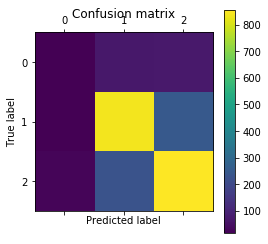

In [89]:
confusionmatrix = confusion_matrix(Y_test, prediction)
print(confusionmatrix)
plt.matshow(confusionmatrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show() 

In [96]:
dataset.corr()

,Year,Bacteria,Active_principle,Value,Open_cycle,Close_cycle,Type_of_medication,Active_principle_mg,DDDA,DCDA,Result
Year,1.000000,-0.068004,-0.056202,0.003607,0.129868,-0.012705,0.007995,-0.058684,-0.057181,-0.048992,0.009095
Bacteria,-0.068004,1.000000,-0.006473,-0.023149,-0.052612,0.050005,0.011465,-0.010569,-0.016846,-0.012456,0.041298
Active_principle,-0.056202,-0.006473,1.000000,0.115287,0.016082,-0.005473,0.074090,-0.053268,-0.010517,-0.028321,-0.206521
Value,0.003607,-0.023149,0.115287,1.000000,-0.044515,-0.007720,0.279958,-0.034872,0.059988,0.037749,0.103622
Open_cycle,0.129868,-0.052612,0.016082,-0.044515,1.000000,-0.249497,-0.063936,-0.052628,-0.048159,-0.041480,0.013432
Close_cycle,-0.012705,0.050005,-0.005473,-0.007720,-0.249497,1.000000,-0.057074,-0.022244,-0.021331,-0.017967,0.013966
Type_of_medication,0.007995,0.011465,0.074090,0.279958,-0.063936,-0.057074,1.000000,0.241515,0.232982,0.197280,-0.090255
Active_principle_mg,-0.058684,-0.010569,-0.053268,-0.034872,-0.052628,-0.022244,0.241515,1.000000,0.902867,0.863281,-0.070218
DDDA,-0.057181,-0.016846,-0.010517,0.059988,-0.048159,-0.021331,0.232982,0.902867,1.000000,0.967801,-0.058289
DCDA,-0.048992,-0.012456,-0.028321,0.037749,-0.041480,-0.017967,0.197280,0.863281,0.967801,1.000000,-0.053613


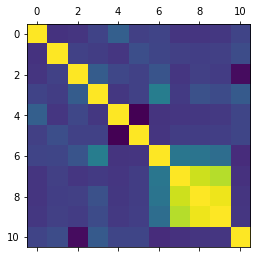

In [97]:
plt.matshow(dataset.corr())
plt.show()

In [94]:
writer1 = pd.ExcelWriter('all_data.xlsx')
all_data.to_excel(writer1,'Sheet1')
writer1.save()

In [95]:
writer2 = pd.ExcelWriter('dataset.xlsx')
dataset.to_excel(writer2,'Sheet1')
writer2.save()